In [1]:
# Distribution functions
from scipy.stats import norm


# Load libraries
import numpy as np
import pandas as pd
import yfinance as yf
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load


# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf


In [2]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
true_alpha = 0.1
true_beta = 0.1
true_sigma0 = 0.2

In [4]:
risk_free_rate = 0.05

In [5]:
def option_vol_from_surface(moneyness, time_to_maturity):
    return true_sigma0 + true_alpha * time_to_maturity + true_beta * np.square(moneyness - 1)

def call_option_price(moneyness, time_to_maturity, option_vol):
    d1=(np.log(1/moneyness)+(risk_free_rate+np.square(option_vol))*time_to_maturity)/(option_vol*np.sqrt(time_to_maturity))
    d2=(np.log(1/moneyness)+(risk_free_rate-np.square(option_vol))*time_to_maturity)/(option_vol*np.sqrt(time_to_maturity))
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)

    return N_d1 - moneyness * np.exp(-risk_free_rate*time_to_maturity) * N_d2

In [6]:
ticker = 'MSFT'  # Microsoft as an example

# Fetch stock data using yfinance
stk = yf.Ticker(ticker)
stk_data = stk.history(period="1y")  # Fetch 1 year of historical data

# Fetch the options expiration dates
exp_dates = stk.options

# Fetch options data for the nearest expiration date
options_data = stk.option_chain(exp_dates[0])

calls = options_data.calls
puts = options_data.puts

print("Stock Data:\n", stk_data.head())
print("\nOptions Data (Calls):\n", calls.head())

Stock Data:
                                  Open        High         Low       Close  \
Date                                                                        
2023-08-31 00:00:00-04:00  326.747451  328.444703  324.345466  325.318176   
2023-09-01 00:00:00-04:00  328.841707  329.516634  324.345458  326.211456   
2023-09-05 00:00:00-04:00  326.548882  332.355305  326.211419  331.064972   
2023-09-06 00:00:00-04:00  330.896299  331.968240  327.720127  330.400024   
2023-09-07 00:00:00-04:00  328.821842  330.598484  326.578669  327.452118   

                             Volume  Dividends  Stock Splits  
Date                                                          
2023-08-31 00:00:00-04:00  26411000        0.0           0.0  
2023-09-01 00:00:00-04:00  14931200        0.0           0.0  
2023-09-05 00:00:00-04:00  18553900        0.0           0.0  
2023-09-06 00:00:00-04:00  17535800        0.0           0.0  
2023-09-07 00:00:00-04:00  18381000        0.0           0.0  

Optio

In [7]:
# Assume the stock price is the last closing price
S = stk_data['Close'].iloc[-1]  # Last closing price of the stock

# Convert expiration date and today's date to timezone-naive
exp_date = pd.to_datetime(exp_dates[0]).tz_localize(None)  # Convert expiration date to datetime and remove timezone
today = pd.to_datetime(stk_data.index[-1]).tz_localize(None)  # Remove timezone from today's date

# Calculate time to maturity in years
Ts = (exp_date - today).days / 365.0  # Time to maturity in years

In [8]:
N = len(calls)  # Use the number of call options available

# Generate moneyness, time to maturity, and implied volatilities
Ks = calls['strike'] / S  # Moneyness: K/S
Sigmas = np.array([option_vol_from_surface(k, Ts) for k in Ks])

# Calculate the call option prices
Ps = np.array([call_option_price(k, Ts, sigma) for k, sigma in zip(Ks, Sigmas)])

# Prepare the dataset
X = np.concatenate([Ks.values.reshape(-1, 1), np.full((N, 1), Ts), Sigmas.reshape(-1, 1)], axis=1)
Y = Ps  # The call option prices are the target variable

# Create a pandas DataFrame
dataset = pd.DataFrame(np.concatenate([Y.reshape(-1, 1), X], axis=1),
                       columns=['Price', 'Moneyness', 'Time', 'Vol'])



In [9]:
# Display the prepared dataset
print(dataset.head())

      Price  Moneyness      Time       Vol
0  0.449155   0.551374  0.019178  0.222044
1  0.425205   0.575346  0.019178  0.219951
2  0.401255   0.599319  0.019178  0.217972
3  0.377305   0.623292  0.019178  0.216109
4  0.353356   0.647265  0.019178  0.214360


In [10]:
pd.set_option('display.precision', 3)
dataset.describe()

,Price,Moneyness,Time,Vol
count,6.200e+01,62.000,6.200e+01,62.000
mean,8.945e-02,0.986,1.918e-02,0.206
std,1.265e-01,0.199,3.498e-18,0.005
min,5.819e-24,0.551,1.918e-02,0.202
25%,7.414e-07,0.866,1.918e-02,0.202
50%,2.676e-02,0.992,1.918e-02,0.204
75%,1.348e-01,1.136,1.918e-02,0.208
max,4.492e-01,1.342,1.918e-02,0.222


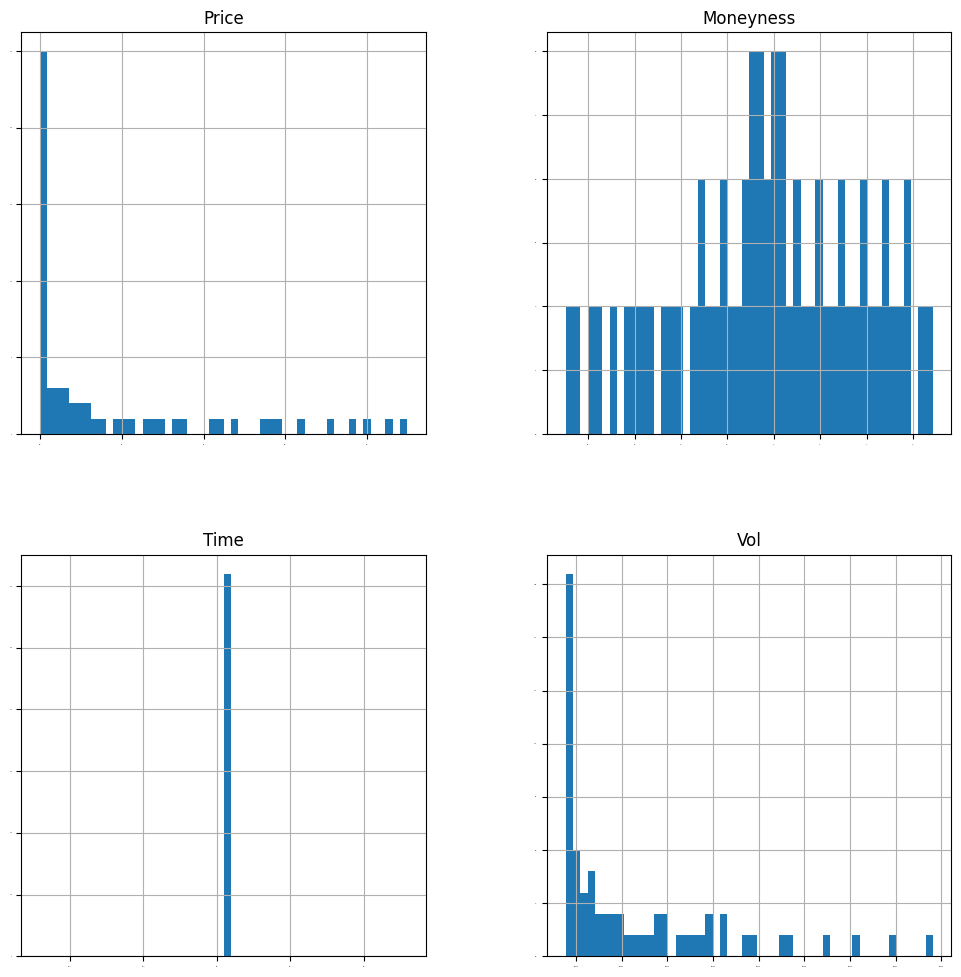

In [11]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

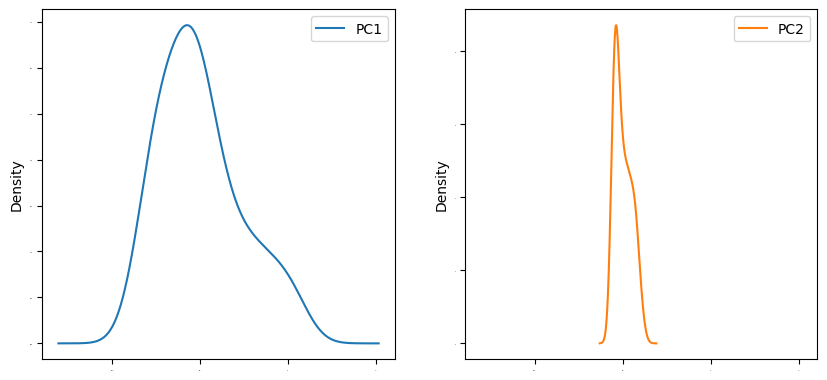

In [12]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 principal components for visualization
pca_data = pca.fit_transform(dataset)

# Convert back to DataFrame for easy plotting
pca_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])

# Plot the density of the principal components
pca_df.plot(kind='density', subplots=True, layout=(2,2), sharex=True, legend=True, fontsize=1, figsize=(10,10))
pyplot.show()

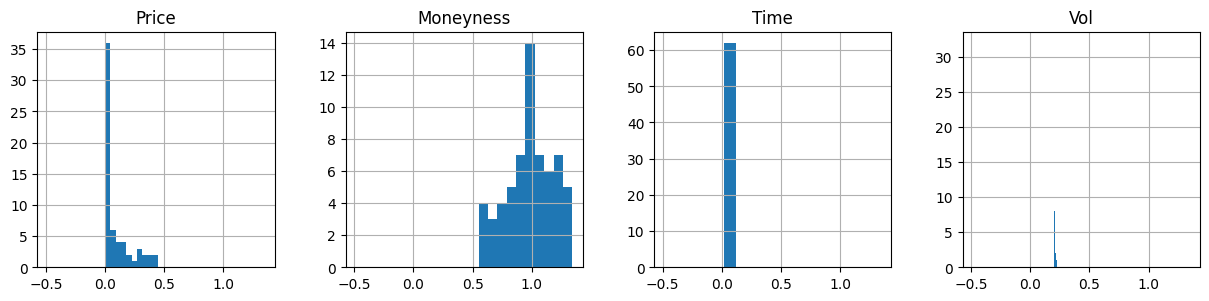

In [13]:
dataset.hist(layout=(4,4), sharex=True, figsize=(15,15))
pyplot.show()

<Axes: title={'center': 'Correlation Matrix'}>

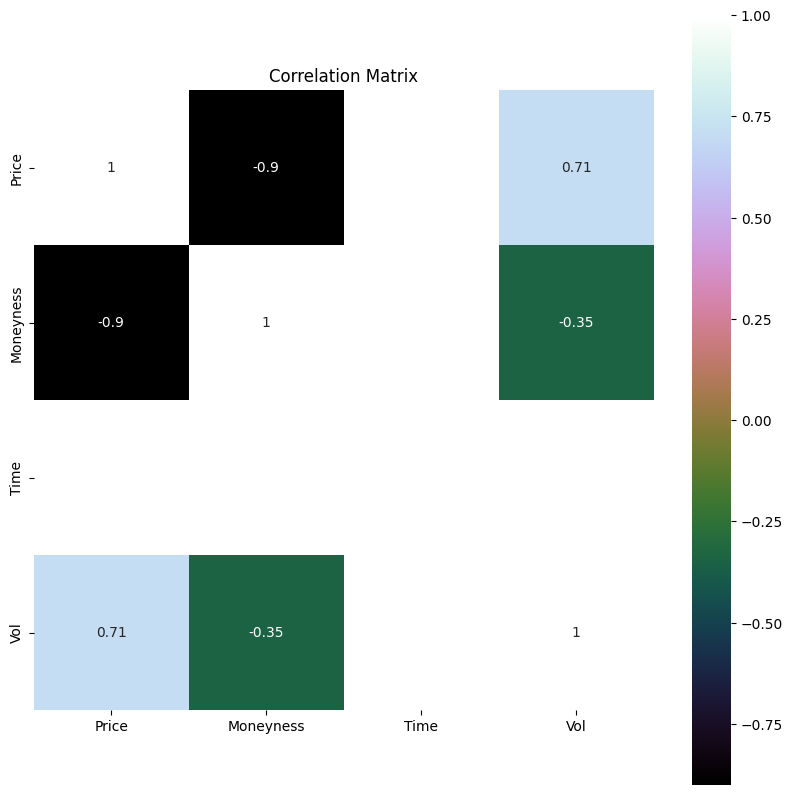

In [14]:
correlation = dataset.corr()
pyplot.figure(figsize=(10,10))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

<Figure size 1500x1500 with 0 Axes>

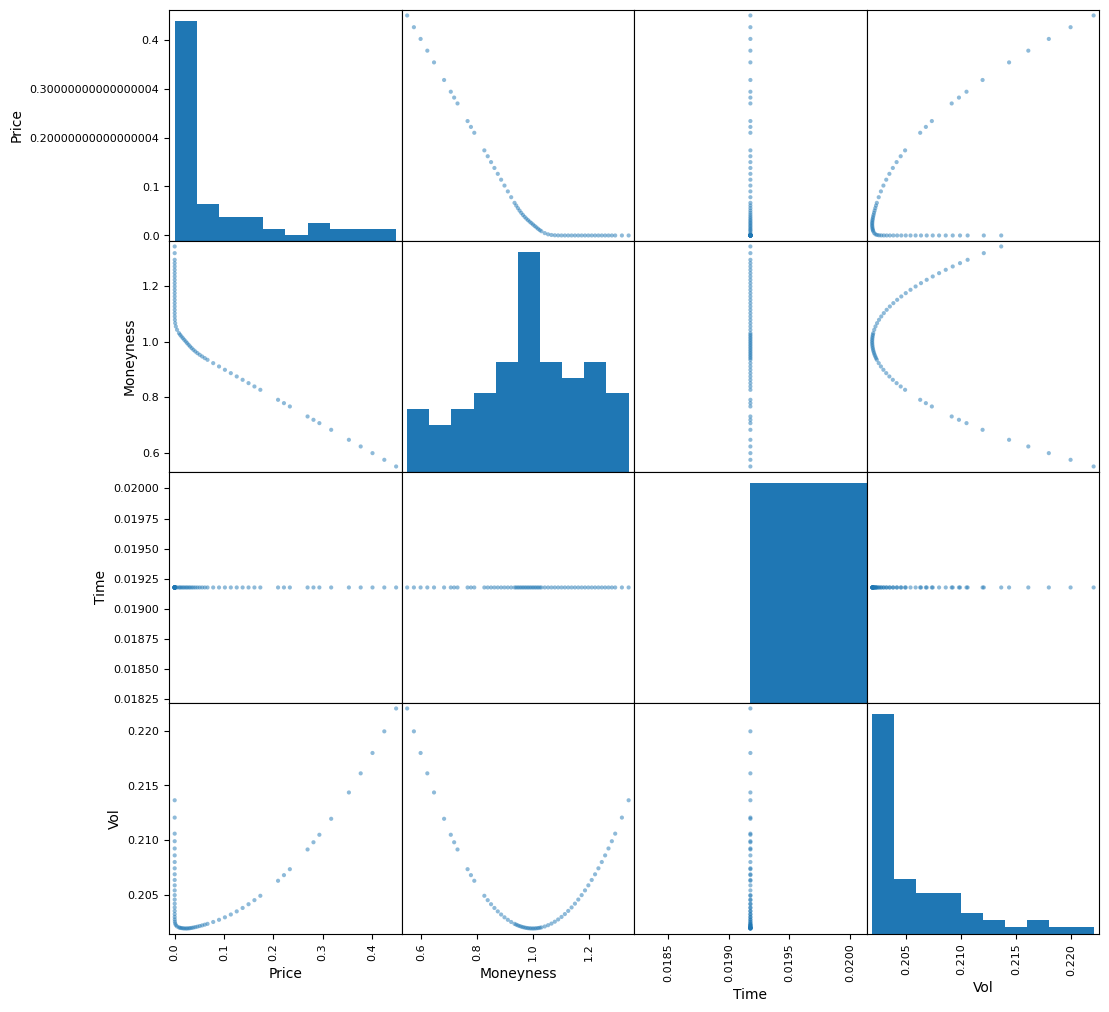

In [15]:
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12))
pyplot.show()

In [16]:
bestfeatures = SelectKBest(k='all', score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(['Moneyness', 'Time', 'Vol'])
#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
Moneyness,258.224
Vol,60.357
Time,0.000


In [17]:
validation_size = 0.2

train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

In [18]:
num_folds = 10
seed = 7
# scikit is moving away from mean_squared_error.
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error'

In [19]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

In [20]:
# Boosting methods
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))

In [21]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)

    ## K Fold analysis:

    kfold = KFold(n_splits=num_folds, shuffle=True,random_state=seed)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)


    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)

    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)

    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.000206 (0.000112) 0.000180 0.000832
LASSO: 0.018276 (0.012290) 0.017245 0.012810
EN: 0.018276 (0.012290) 0.017245 0.012810
KNN: 0.000201 (0.000369) 0.000080 0.000000
CART: 0.000155 (0.000133) 0.000000 0.046595
SVR: 0.006098 (0.001061) 0.006052 0.003604
GBR: 0.000137 (0.000144) 0.000000 0.006916
RFR: 0.000092 (0.000101) 0.000014 0.009335


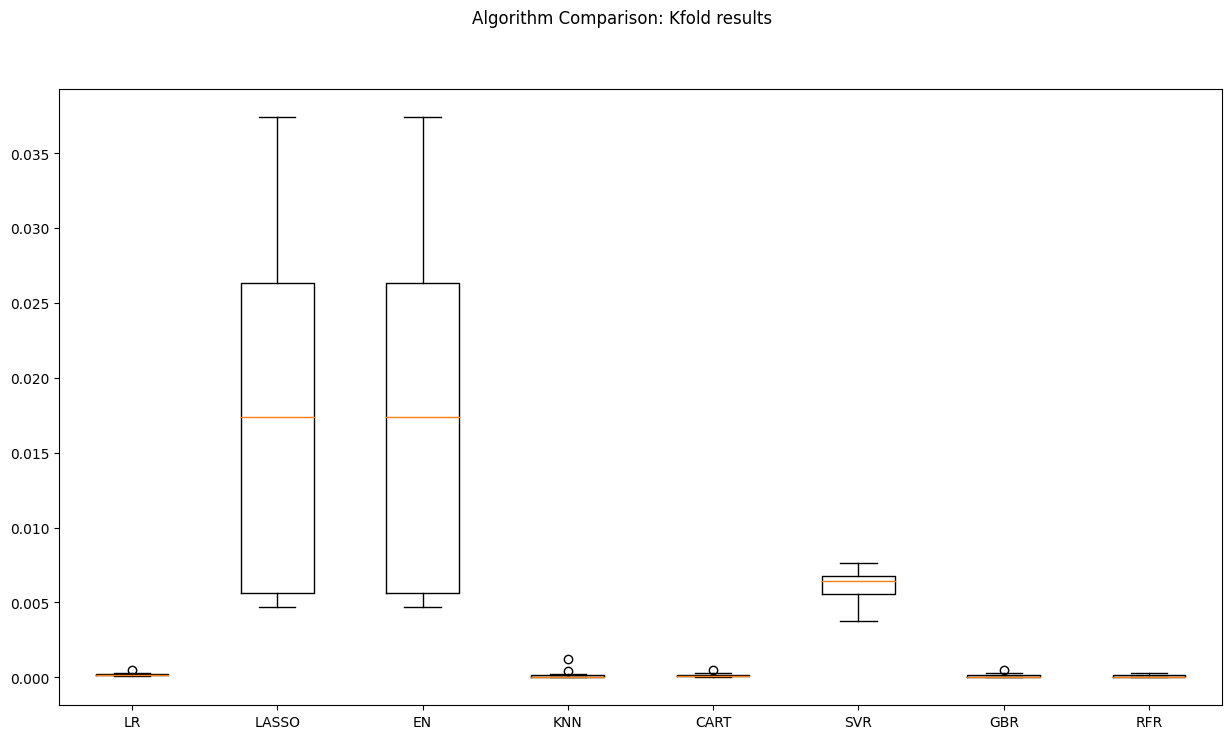

In [22]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

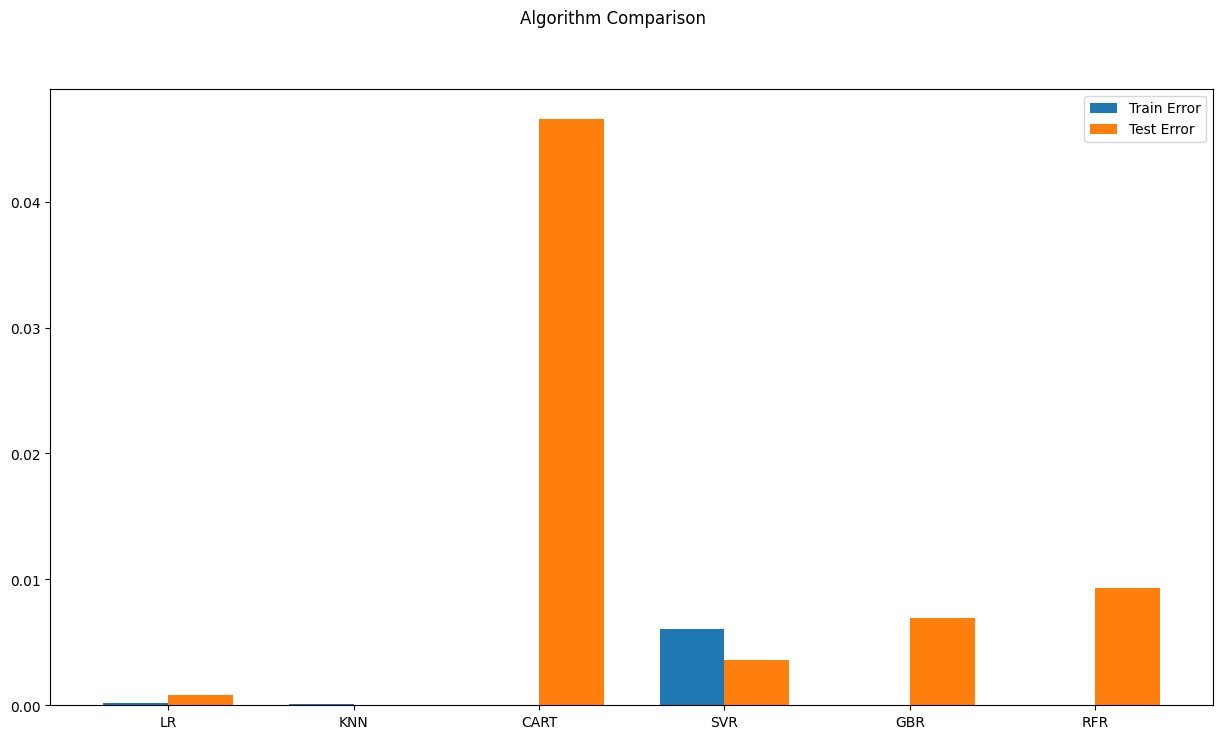

In [23]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names)-2)  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results[0:1] + train_results[3:],  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results[0:1] + test_results[3:], width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names[0:1] + names[3:])
pyplot.show()

In [28]:
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel type
    'epsilon': [0.01, 0.1, 0.2, 0.5],  # Epsilon in the epsilon-SVR model
    'gamma': ['scale', 'auto']  # Kernel coefficient
}

model = SVR()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold, n_jobs=-1)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Output the results for each parameter combination
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Save the best parameters
best_params = grid_result.best_params_

Best: -0.000064 using {'C': 10, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}
-0.006416 (0.005784) with: {'C': 0.1, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
-0.003669 (0.002874) with: {'C': 0.1, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'poly'}
-0.000313 (0.000276) with: {'C': 0.1, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}
-0.035942 (0.030137) with: {'C': 0.1, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'sigmoid'}
-0.006416 (0.005784) with: {'C': 0.1, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'linear'}
-0.017134 (0.015165) with: {'C': 0.1, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'}
-0.009478 (0.008533) with: {'C': 0.1, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}
-0.015573 (0.013594) with: {'C': 0.1, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'sigmoid'}
-0.009937 (0.004253) with: {'C': 0.1, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
-0.005184 (0.002115) with: {'C': 0.1, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
-0

In [29]:
model_tuned = SVR(
    C=best_params['C'],
    kernel=best_params['kernel'],
    epsilon=best_params['epsilon'],
    gamma=best_params['gamma']
)

In [30]:
model_tuned.fit(X_train, Y_train)

SVR(C=10, epsilon=0.01)

In [31]:
predictions = model_tuned.predict(X_test)
mse = mean_squared_error(Y_test, predictions)
print(f"Mean Squared Error on test set: {mse}")

Mean Squared Error on test set: 0.00020576477786276895
